## Leitura dos Dados

In [ ]:
## Importando módulos necessários
import numpy as np
import pandas as pd
from zipfile import ZipFile
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
## Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Lendo os arquivos
# Determinando o Caminho
# sCaminho = '/content/drive/MyDrive/Projetos/IDP/MBA/SetorPublicoI/PNADC/'
sCaminho = "/content/drive/Othercomputers/Meu modelo MacBook Air/Documents/IPEA/Curso IDP/"

## Lendo o arquivo zipado
# Leitura feita no R e dados já filtrados para NaNs de renda e para apenas pessoas em idade ativa
sArquivo = f"{sCaminho}PNADC_042019.zip"

with ZipFile(sArquivo) as z:
    df = pd.read_csv(z.open("PNADC_042019.csv"))
    print(*z.namelist(),sep="\n")

PNADC_042019.csv


In [ ]:
## Importante: os valores nulos de renda (VD4020) não são pessoas que ganham 0; são pessoas que NÃO TRABALHAM
# Para retirar essas pessoas da base original, 
# df.dropna(subset=['VD4020'], inplace=True)

## Retirando pessoas em idade não-ativa
# df = df.loc[(df["V2009"] >= 15) & (df["V2009"] <= 65)]

In [ ]:
## Vendo o tamanho da base (lembrando que ela já está filtrada)
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 214289; Colunas: 39


In [ ]:
## Filtrando apenas para o Centro-Oeste
df = df.loc[df["UF"].isin([50, 51, 52, 53])]
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 24212; Colunas: 39


## Preparação da base

In [ ]:
## Criando a coluna de identificação dos domicilios
df['iddom'] = df['UPA'].astype(str) + df['V1008'].astype(str) + df['V1014'].astype(str)
df['idind'] = df['iddom'] + df['V2003'].astype(str)

In [ ]:
## Criando idade e idade ao quadrado
df.rename(columns={"V2009":"idade"}, inplace=True)
df['idadesq'] = df['idade'] ** 2

In [ ]:
## Gênero (dummy feminina, mais especificamente)
df['feminino'] = df['V2007'] - 1

## Alternativamente
# df['feminino'] = df["V2007"].apply(lambda i: 1 if i == 2 else 0)

In [ ]:
## V2010: cor
# Substituindo os números pelo nomes e vendo a quantidade
df["V2010"].replace([1,2,3,4,5,9], ['branca','preta','amarela','parda','indigena',np.nan], inplace=True)
df['V2010'].value_counts(dropna=False)

parda       13093
branca       8341
preta        2491
amarela       153
indigena      130
NaN             4
Name: V2010, dtype: int64

In [ ]:
## Renomeando cor
df.rename(columns={"V2010":"cor"}, inplace=True)

In [ ]:
## criando as dummies e juntando-as ao dataframe
df = pd.concat([df, pd.get_dummies(df['cor'])], axis=1)

In [ ]:
## Vendo se está tudo ok
df[['cor', 'branca','preta','amarela','parda','indigena']]

,cor,branca,preta,amarela,parda,indigena
190077,branca,1,0,0,0,0
190078,parda,0,0,0,1,0
190079,parda,0,0,0,1,0
190080,branca,1,0,0,0,0
190081,branca,1,0,0,0,0
...,...,...,...,...,...,...
214284,branca,1,0,0,0,0
214285,parda,0,0,0,1,0
214286,preta,0,1,0,0,0
214287,branca,1,0,0,0,0


In [ ]:
## Grau de Educação
# Substituindo os números pelo nomes e vendo a quantidade
df["VD3004"].replace([1,2,3,4,5,6,7], ['sem_instrucao','fund_incompleto','fund_completo','medio_incompleto','medio_completo','superior_incompleto','superior_completo'], inplace= True)
df['VD3004'].value_counts(normalize=True, dropna=False)*100

medio_completo         31.042458
fund_incompleto        23.967454
superior_completo      21.204361
medio_incompleto        7.962994
fund_completo           7.488022
superior_incompleto     6.699157
sem_instrucao           1.635553
Name: VD3004, dtype: float64

In [ ]:
## criando as dummies e juntando-as ao dataframe
df = pd.concat([df, pd.get_dummies(df['VD3004'])], axis = 1)

In [ ]:
## V1022: domicilios rurais
df['rural'] = df['V1022'] - 1

In [ ]:
## Vendo proporções
df['rural'].value_counts(normalize=True, dropna=False)*100

0    84.928961
1    15.071039
Name: rural, dtype: float64

In [ ]:
## VD4001: força de trabalho (mais especificamente, fora dela)
df['VD4001'] = df['VD4001'] - 1

## VD4002: ocupação (mais especificamente, pessoas desocupadas)
df['VD4002'] = df['VD4002'] - 1

In [ ]:
#### dummies de ocupação ######
## tipo de trabalho
# mais agregado
df['VD4008'].replace([1,2,3,4,5,6], ['privado','domestico','publico','empregador','conta_propria','familiar'], inplace=True)
df = pd.concat([df,pd.get_dummies(df['VD4008'])], axis=1)

# desagregado
df["VD4009"].replace([1,2,3,4,5,6,7,8,9,10], ['privado_formal','privado_informal','domestico_formal','domestico_informal','publico_formal','publico_informal','militar','empregador1','conta_propria','familiar'], inplace= True)
df = pd.concat([df,pd.get_dummies(df['VD4009'])], axis=1)

## setor de ocupação
df['VD4010'] = df['VD4010'].replace([1,2,3,4,5,6,7,8,9,10,11,12], ['agro','industria','construcao','comercio','transporte','aloj_alim','servicos','adm_publica','educ_saude','outros_servicos','servicos_domesticos','ativ_mal_definidas'])
df = pd.concat([df,pd.get_dummies(df['VD4010'])], axis=1)

In [ ]:
## Renomendo educação
df.rename(columns={"VD3005":"educ","VD3004":"grau_educ"}, inplace=True)

## Análises de Renda

Qual variável de renda usar?

In [ ]:
## Vamos usar renda habitual total controlada por horas, por dois motivos:
# 1. Não há nenhum caso em que a renda habitual seja 0, o que facilita a logaritimização e linearização do modelo
# 2. Menos sensível à sazonalidade (fim de ano costuma ter mais renda efetiva em virtude de bônus e contratações temporárias)

# Renomeando as rendas
nomes_renda = {'VD4016':'renda_hab_prin','VD4017':'renda_efet_prin','VD4019':'renda_hab_tot','VD4020':'renda_efet_tot','VD4031':'horas_hab_tot','VD4032':'horas_efet_prin','VD4035':'horas_efet_tot'}
df.rename(columns = nomes_renda, inplace = True)

In [ ]:
## ATENÇÃO: O PAINEL SÓ CONTÉM DADOS DE RENDIMENTOS DO TRABALHO (sem benefícios previdenciários)
## Vendo estatísticas das diferentes rendas e horas trabalhadas
df[['renda_hab_tot','renda_hab_prin','renda_efet_tot','renda_efet_prin','horas_hab_tot','horas_efet_tot']].describe()

,renda_hab_tot,renda_hab_prin,renda_efet_tot,renda_efet_prin,horas_hab_tot,horas_efet_tot
count,24212.000000,24208.000000,24212.000000,24208.000000,24212.000000,24212.000000
mean,2455.918305,2395.420522,2511.364406,2450.456378,40.457707,38.804105
std,3187.614363,3091.453755,3357.251733,3258.353264,11.515607,13.561983
min,20.000000,20.000000,0.000000,0.000000,1.000000,0.000000
25%,1000.000000,1000.000000,1000.000000,1000.000000,40.000000,36.000000
50%,1500.000000,1500.000000,1500.000000,1500.000000,40.000000,40.000000
75%,2500.000000,2500.000000,2800.000000,2600.000000,44.000000,44.000000
max,100000.000000,100000.000000,100000.000000,100000.000000,120.000000,120.000000


In [ ]:
## Para controlar para a oferta de horas de trabalho (mulheres ofertam menos horas)
# dividimos pelo número de horas trabalhadas, o que é mais um motivo para usar rendas habituais
# (rendas efetivas possuem alguns 0, o que causaria problemas de divisão)

df['renda_hab_hora'] = df['renda_hab_tot']/(df['horas_hab_tot']*4)
df['lsalariohora'] = np.log(df['renda_hab_hora'])

## Médias de renda por gênero

In [ ]:
## Média por gênero
df.groupby('feminino')['renda_hab_hora'].mean()

feminino
0    16.519633
1    14.929314
Name: renda_hab_hora, dtype: float64

In [ ]:
from scipy import stats

## Subamostra de homens
vRendaHomens = df['renda_hab_hora'].loc[df['feminino'] == 0]

## Subamostra de mulheres
vRendaMulheres = df['renda_hab_hora'].loc[df['feminino'] == 1]

In [ ]:
## Teste
stats.ttest_ind(vRendaHomens, vRendaMulheres, nan_policy='omit')

## Vimos que há uma clara disparidade de gênero e raça no salário, mas como medir isso mais precisamente? Regressões lineares!

In [ ]:
## Importando o módulo
from statsmodels.formula.api import ols

In [ ]:
## Criando fórmula
# Sintaxe: "y ~ x1 + x2 + x3...."
formula = "lsalariohora ~ feminino"

## Modelo
modelo_ruim = ols(formula, df).fit(use_t=True)

## Vendo os resultados
print(modelo_ruim.summary())

                            OLS Regression Results                            
Dep. Variable:           lsalariohora   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     100.4
Date:                Tue, 19 Oct 2021   Prob (F-statistic):           1.41e-23
Time:                        23:47:34   Log-Likelihood:                -27824.
No. Observations:               24212   AIC:                         5.565e+04
Df Residuals:                   24210   BIC:                         5.567e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4367      0.006    375.583      0.0

In [ ]:
## Modelo lin-lin
formula_linlin = "renda_hab_hora ~ educ + idade + feminino + preta + parda + amarela + indigena"
modelo_linlin = ols(formula_linlin, df).fit(use_t=True)

## Vendo os resultados
print(modelo_linlin.summary())

                            OLS Regression Results                            
Dep. Variable:         renda_hab_hora   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     307.1
Date:                Tue, 19 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:47:34   Log-Likelihood:            -1.1660e+05
No. Observations:               24212   AIC:                         2.332e+05
Df Residuals:                   24204   BIC:                         2.333e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5234      1.034    -18.890      0.0

In [ ]:
## Modelo mais completo com educ, idade, gênero e disparidades raciais
formula_simples = "lsalariohora ~ educ + idade + feminino + preta + parda + amarela + indigena"
modelo_simples = ols(formula_simples, df).fit(use_t=True)

## Vendo os resultados
print(modelo_simples.summary())

                            OLS Regression Results                            
Dep. Variable:           lsalariohora   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     1363.
Date:                Tue, 19 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:47:34   Log-Likelihood:                -23853.
No. Observations:               24212   AIC:                         4.772e+04
Df Residuals:                   24204   BIC:                         4.779e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8430      0.022     37.595      0.0

In [ ]:
## Preto e pardos são iguais?
H0 = "parda = preta"
modelo_simples.wald_test(H0)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.00185108]]), p=0.9656826260259329, df_denom=2.42e+04, df_num=1>

In [ ]:
## Modelo mais completo com educ, educ2, idade, idade2, gênero e disparidades raciais
# Polinômios de educ e idade: tentar captar não-linearidades!
df['educsq'] = df['educ']**2

formula_completa = "lsalariohora ~ educ + educsq + idade + idadesq + feminino + preta + parda + amarela + indigena"
modelo_completo = ols(formula_completa, df).fit(use_t=True)

## Vendo os resultados
print(modelo_completo.summary())

## O que ainda pode melhorar...?

                            OLS Regression Results                            
Dep. Variable:           lsalariohora   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1354.
Date:                Tue, 19 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:47:34   Log-Likelihood:                -22937.
No. Observations:               24212   AIC:                         4.589e+04
Df Residuals:                   24202   BIC:                         4.598e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7851      0.047     16.855      0.0

## Testando as hipóteses do modelo de Regressão Linear

In [ ]:
## Caso o import abaixo dê erro, rodar: (demora um pouquinho)
"""
! pip install --upgrade Cython
! pip install --upgrade git+https://github.com/statsmodels/statsmodels
import statsmodels.api as sm
"""

'\n! pip install --upgrade Cython\n! pip install --upgrade git+https://github.com/statsmodels/statsmodels\nimport statsmodels.api as sm\n'

In [ ]:
## Importando alguns módulos de teste
# Caso dê errado, vide célula acima (statsmodels do colab é desatualizado)
# Versão Colab: 0.10.2; Versão Atual: 0.14.0
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
import statsmodels.stats.api as sms
from patsy import dmatrices

In [ ]:
## Função que faz os testes
def ols_diagnostics(formula, model, data, y_string):
    """
    Given the OLS model supplied, calculates statistics and draws graphs that check the Multiple Linear Regressions hypothesis.
    References:
        https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html
        https://medium.com/@vince.shields913/regression-diagnostics-fa476b2f64db
    :param formula : patsy formula of the model;
    :param model : fitted model object;
    :param data : DataFrame containing the data; 
    :param y_string : string (name) of the dependent variable
    """

    ## Reset: specification of tue functional form of the model the model
    reset = linear_reset(model, power=3, use_f=True, cov_type='HC1')
    print(f"Linear Reset P-value: {reset.pvalue}")
    print("H0: model is well specificed and linear.")
    print("For more information, see the Residuals vs Fitted Values plot.\n")

    ### Condition number: multicollinearity
    print(f"Condition Number for Multicollinearity: {round(np.linalg.cond(model.model.exog), 2)}")
    print("The larger the number (> 10.000), the bigger the multicollinearity. For more information, see the 'VIF' plot.\n")

    ## Calculating Variance Influence Factors (VIF)
    # Matrices
    y, X = dmatrices(formula, data, return_type='dataframe')

    ## Calcuating VIFs and storing in a DataFrame
    dfVIF = pd.DataFrame()
    dfVIF["Variáveis"] = X.columns
    dfVIF["Fator_VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    ## Breusch-Pagan: 
    print(f"Breusch-Pagan P-value for heteroskedasticity: {round(sms.het_breuschpagan(model.resid, model.model.exog)[3], 4)}")
    print("H0: Variance is homoskedasticity.")
    print("For more information, see the 'Scale-Location' plot.\n")

    ## Durbin-Watson: correlation between the residuals
    print(f"Durbin-Watson statistic is: {np.around(durbin_watson(model.resid), 2)}")
    print("If the value is close to 0, there is positive serial correlation.")
    print("If the value is close to 4, there is negative serial correlation.")
    print("Rule of thumb: 1.5 < DW < 2.5 indicates no serial correlation.\n")
    
    ## Jarque-Bera: normality of the residuals (MLR 6, used for statistic inference)
    print(f"Jarque-Bera P-value: {np.around(sms.jarque_bera(model.resid)[1], 4)}")
    print("H0: Data has a normal distribution.")
    print("For more information, see the 'Normal Q-Q' plot.\n")

    ## Creating graphic object
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))
    plt.style.use('seaborn-white')

    ### Plots
    ## Linearity: residuals x predicted values. The less inclined the lowess, the more linear the model.
    ax00 = sns.residplot(x=model.fittedvalues, y=y_string, data=data, lowess=True,
                         scatter_kws={'facecolors':'none', 'edgecolors':'black'},
                         line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax[0, 0])
    
    # Titles
    ax00.set_title('Linearity: Residuals vs Fitted', fontsize=12)
    ax00.set_xlabel('Fitted Values', fontsize=10)
    ax00.set_ylabel('Residuals (horizontal lowess: linearity)', fontsize=10)

    ## Multicollinearity: VIF
    ax01 = dfVIF["Fator_VIF"].plot(kind='bar', stacked=False, ax=ax[0, 1])

    # X tick labels
    ax01.set_xticklabels(labels=dfVIF["Variáveis"], rotation=0, color='k')

    # Annotations
    for p in ax01.patches:                 
        ax01.annotate(round(p.get_height(), 2), (p.get_x()+p.get_width()/2., p.get_height()), 
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    ## Titles
    ax01.set_title("Multicollinearity Test - VIF", color = 'k', fontsize=12)
    ax01.set_ylabel("Variance Influence Factor (> 5: multicollinearity)", color = 'k', fontsize=10)
    ax01.set_xlabel("Variable", color = 'k', fontsize=10)

    ## Heteroskedasticity: the more disperse and horizontal are the points, the more likely it is that homoskedasticity is present
    ax10 = sns.regplot(x=model.fittedvalues, y=np.sqrt(np.abs(model.get_influence().resid_studentized_internal)), 
                       scatter=True, ci=False,  lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                       scatter_kws={'facecolors':'none', 'edgecolors':'black'}, ax=ax[1, 0])

    # Titles
    ax10.set_title('Heteroskedasticity: Scale-Location', fontsize=12)
    ax10.set_xlabel('Fitted Values', fontsize=10)
    ax10.set_ylabel('$\sqrt{|Standardized Residuals|}$ (disperse and horizontal: homoskedasticity)', fontsize=10)

    ## Normality of the residuals: Q-Q Plot
    probplot = sm.ProbPlot(model.get_influence().resid_studentized_internal, fit=True)
    ax11 = probplot.qqplot(line='45', marker='o', color='black', ax=ax[1, 1])

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


Linear Reset P-value: 4.826783800228538e-204
H0: model is well specificed and linear.
For more information, see the Residuals vs Fitted Values plot.

Condition Number for Multicollinearity: 580.57
The larger the number (> 10.000), the bigger the multicollinearity. For more information, see the 'VIF' plot.

Breusch-Pagan P-value for heteroskedasticity: 0.0167
H0: Variance is homoskedasticity.
For more information, see the 'Scale-Location' plot.

Durbin-Watson statistic is: 1.84
If the value is close to 0, there is positive serial correlation.
If the value is close to 4, there is negative serial correlation.
Rule of thumb: 1.5 < DW < 2.5 indicates no serial correlation.

Jarque-Bera P-value: 0.0
H0: Data has a normal distribution.
For more information, see the 'Normal Q-Q' plot.



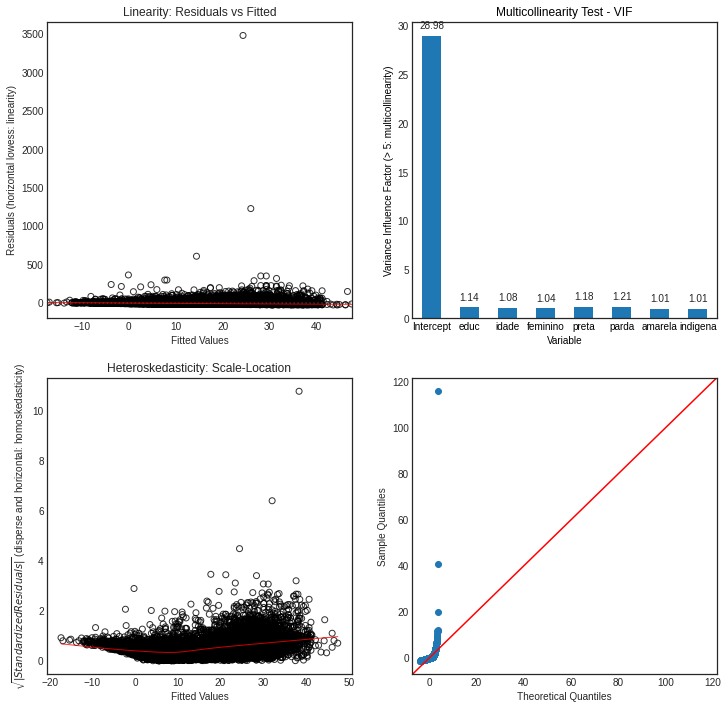

In [ ]:
# Diagnóstico do Modelo Lin-Lin
# formula_linlin = "renda_hab_hora ~ educ + idade + feminino + preta + parda + amarela + indigena"
ols_diagnostics(formula_linlin, modelo_linlin, df, "renda_hab_hora")

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


Linear Reset P-value: 4.579622505857632e-177
H0: model is well specificed and linear.
For more information, see the Residuals vs Fitted Values plot.

Condition Number for Multicollinearity: 580.57
The larger the number (> 10.000), the bigger the multicollinearity. For more information, see the 'VIF' plot.

Breusch-Pagan P-value for heteroskedasticity: 0.0
H0: Variance is homoskedasticity.
For more information, see the 'Scale-Location' plot.

Durbin-Watson statistic is: 1.56
If the value is close to 0, there is positive serial correlation.
If the value is close to 4, there is negative serial correlation.
Rule of thumb: 1.5 < DW < 2.5 indicates no serial correlation.

Jarque-Bera P-value: 0.0
H0: Data has a normal distribution.
For more information, see the 'Normal Q-Q' plot.



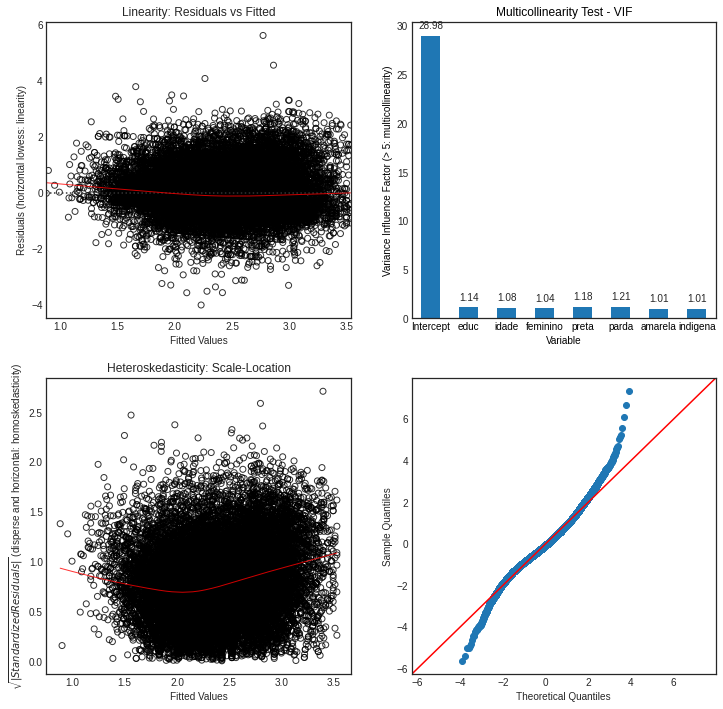

In [ ]:
# Diagnóstico do Modelo Simples
ols_diagnostics(formula_simples, modelo_simples, df, "lsalariohora")

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


Linear Reset P-value: 7.089635462679579e-111
H0: model is well specificed and linear.
For more information, see the Residuals vs Fitted Values plot.

Condition Number for Multicollinearity: 26714.38
The larger the number (> 10.000), the bigger the multicollinearity. For more information, see the 'VIF' plot.

Breusch-Pagan P-value for heteroskedasticity: 0.0
H0: Variance is homoskedasticity.
For more information, see the 'Scale-Location' plot.

Durbin-Watson statistic is: 1.6
If the value is close to 0, there is positive serial correlation.
If the value is close to 4, there is negative serial correlation.
Rule of thumb: 1.5 < DW < 2.5 indicates no serial correlation.

Jarque-Bera P-value: 0.0
H0: Data has a normal distribution.
For more information, see the 'Normal Q-Q' plot.



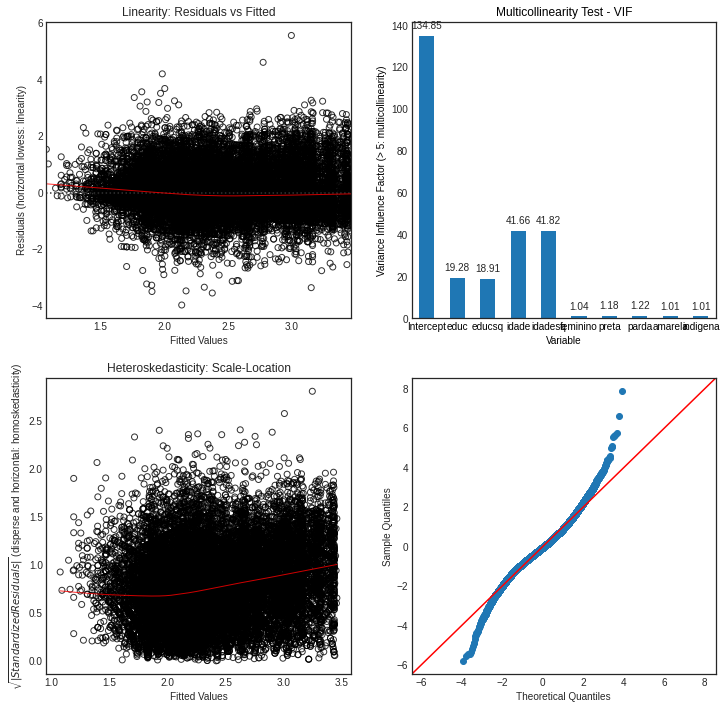

In [ ]:
# Diagnóstico do Modelo Completo
# Tá melhor, mas ainda muito longe de uma especificação completa
# Há muitos outros fatores que não estão presentes aqui (setor de atividade, posição na ocupação, formalidade...)
# que afetam salários (vide R2 de 0.33)

# Maior multicolinearidade porque incluiu-se educ, educsq e idade, idadesq
ols_diagnostics(formula_completa, modelo_completo, df, "lsalariohora")

In [ ]:
## Modelo mais completo com variáveis ocupacionais
formula_completa1 = "lsalariohora ~ educ + educsq + idade + idadesq + feminino + preta + parda + amarela + indigena + C(VD4009)"
modelo_completo1 = ols(formula_completa1, df).fit(use_t=True)

## Vendo os resultados
print(modelo_completo1.summary())

                            OLS Regression Results                            
Dep. Variable:           lsalariohora   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     876.6
Date:                Wed, 20 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:07:29   Log-Likelihood:                -21796.
No. Observations:               24212   AIC:                         4.363e+04
Df Residuals:                   24193   BIC:                         4.378e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


Linear Reset P-value: 1.806628463716531e-82
H0: model is well specificed and linear.
For more information, see the Residuals vs Fitted Values plot.

Condition Number for Multicollinearity: 150871.21
The larger the number (> 10.000), the bigger the multicollinearity. For more information, see the 'VIF' plot.

Breusch-Pagan P-value for heteroskedasticity: 0.0
H0: Variance is homoskedasticity.
For more information, see the 'Scale-Location' plot.

Durbin-Watson statistic is: 1.62
If the value is close to 0, there is positive serial correlation.
If the value is close to 4, there is negative serial correlation.
Rule of thumb: 1.5 < DW < 2.5 indicates no serial correlation.

Jarque-Bera P-value: 0.0
H0: Data has a normal distribution.
For more information, see the 'Normal Q-Q' plot.



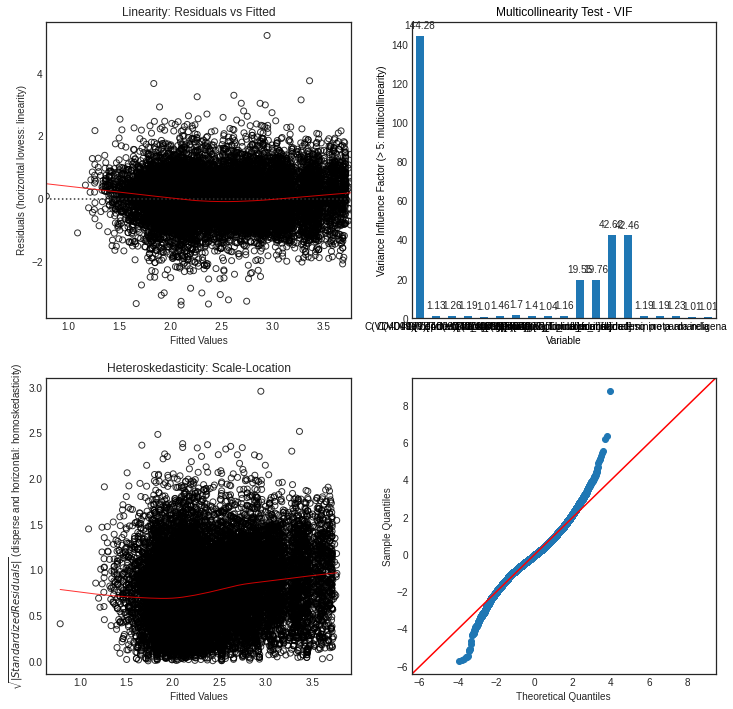

In [ ]:
ols_diagnostics(formula_completa1, modelo_completo1, df, "lsalariohora")

In [ ]:
## Modelo completão
modelo_completo1_heteroscedasticidade = ols(formula_completa1, df).fit(use_t=True, cov_type="HC1")

## Vendo os resultados
print(modelo_completo1_heteroscedasticidade.summary())

                            OLS Regression Results                            
Dep. Variable:           lsalariohora   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     709.0
Date:                Wed, 20 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:18:52   Log-Likelihood:                -21796.
No. Observations:               24212   AIC:                         4.363e+04
Df Residuals:                   24193   BIC:                         4.378e+04
Df Model:                          18                                         
Covariance Type:                  HC1                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


Linear Reset P-value: 1.806628463716531e-82
H0: model is well specificed and linear.
For more information, see the Residuals vs Fitted Values plot.

Condition Number for Multicollinearity: 150871.21
The larger the number (> 10.000), the bigger the multicollinearity. For more information, see the 'VIF' plot.

Breusch-Pagan P-value for heteroskedasticity: 0.0
H0: Variance is homoskedasticity.
For more information, see the 'Scale-Location' plot.

Durbin-Watson statistic is: 1.62
If the value is close to 0, there is positive serial correlation.
If the value is close to 4, there is negative serial correlation.
Rule of thumb: 1.5 < DW < 2.5 indicates no serial correlation.

Jarque-Bera P-value: 0.0
H0: Data has a normal distribution.
For more information, see the 'Normal Q-Q' plot.



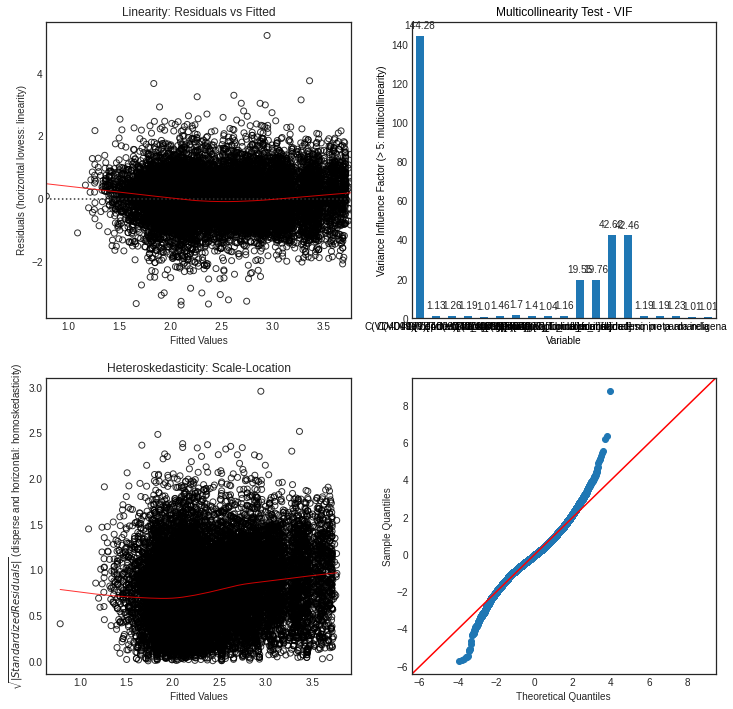

In [ ]:
ols_diagnostics(formula_completa1, modelo_completo1_heteroscedasticidade, df, "lsalariohora")

### Como consertar heteroscedasticidade?

1. Se você conhecer a forma da heteroscedasticidade (muito difícil): Mínimos Quadrados Ponderados

- Casos clássicos: 

    - Se, ao invés de dados individuais, possuirmos apenas dados médios de algum grupo ou região geográfica; 
    - Modelo de probabilidade linear (para uma discussão muito boa e inteligível, ver Introdução à Econometria do Wooldridge, Seções 8.4 até o fim do capítulo 8)

2. Usar erros padrão robusto! Em python, eles são tidos como HC1 (iguais à opção *robust* no STATA)

Vale ressaltar que a heteroscedasticidade não afeta a estimativa dos Betas, mas sim seu intervalo de confiância.

In [ ]:
## Modelo com educ, idade, gênero e disparidades raciais
modelo_simples_heteroscedasticidade = ols(formula_simples, df).fit(use_t=True, cov_type="HC1")

## Vendo os resultados
print(modelo_simples_heteroscedasticidade.summary())

                            OLS Regression Results                            
Dep. Variable:           lsalariohora   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     1038.
Date:                Wed, 20 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:14:36   Log-Likelihood:                -23853.
No. Observations:               24212   AIC:                         4.772e+04
Df Residuals:                   24204   BIC:                         4.779e+04
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8430      0.024     35.734      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


Linear Reset P-value: 4.579622505946923e-177
H0: model is well specificed and linear.
For more information, see the Residuals vs Fitted Values plot.

Condition Number for Multicollinearity: 580.57
The larger the number (> 10.000), the bigger the multicollinearity. For more information, see the 'VIF' plot.

Breusch-Pagan P-value for heteroskedasticity: 0.0
H0: Variance is homoskedasticity.
For more information, see the 'Scale-Location' plot.

Durbin-Watson statistic is: 1.56
If the value is close to 0, there is positive serial correlation.
If the value is close to 4, there is negative serial correlation.
Rule of thumb: 1.5 < DW < 2.5 indicates no serial correlation.

Jarque-Bera P-value: 0.0
H0: Data has a normal distribution.
For more information, see the 'Normal Q-Q' plot.



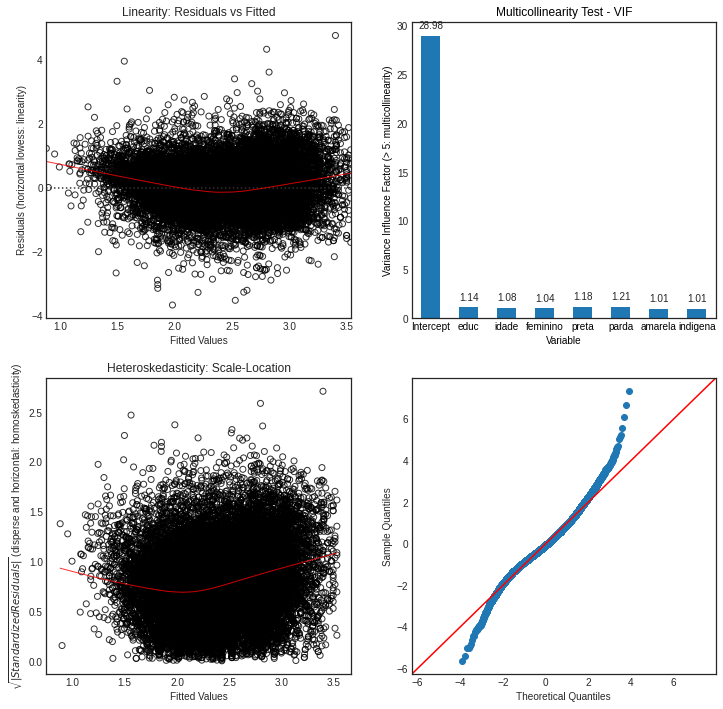

In [ ]:
ols_diagnostics(formula_simples, modelo_simples_heteroscedasticidade, df, "lsalariohora")

## Testando Outliers

In [ ]:
def cooks_distance(model):
    """
    Calculates and plots the Cooks Distance metric, which shows the influence of individual points in the regression results.
    If a point is above D = 0.5, then it affects the results and can be considered an outlier.
    References: https://medium.com/@vince.shields913/regression-diagnostics-fa476b2f64db
    :param model: fitted OLS model object.
    """

    ## Defining theme
    plt.style.use('seaborn-white')

    ## Creating functions that define D = 0.5 and D = 1.0
    def one_line(x):
        return np.sqrt((1 * len(model.params) * (1 - x)) / x)

    def point_five_line(x):
        return np.sqrt((0.5 * len(model.params) * (1 - x)) / x)
    
    def show_cooks_distance_lines(tx,inc,color,label):
        plt.plot(inc, tx(inc), label=label, color=color, ls='--')
    
    ## Plotting
    sns.regplot(x=model.get_influence().hat_matrix_diag, y=model.get_influence().resid_studentized_internal, 
                scatter=True, ci=False, lowess=True, line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8},
                scatter_kws={'facecolors':'none', 'edgecolors':'black'})
    
    show_cooks_distance_lines(one_line, np.linspace(.01,.14,100), 'red', 'Cooks Distance (D=1)' )

    show_cooks_distance_lines(point_five_line, np.linspace(.01,.14,100), 'black', 'Cooks Distance (D=0.5)')

    plt.title('Residuals vs Leverage', fontsize=12)
    plt.xlabel('Leverage', fontsize=10)
    plt.ylabel('Standardized Residuals', fontsize=10)
    plt.legend()

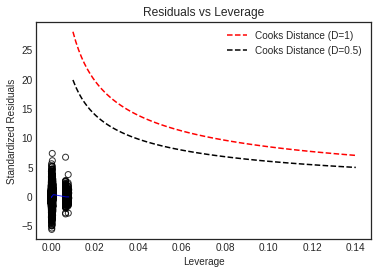

In [ ]:
## Modelo Simples
cooks_distance(modelo_simples)

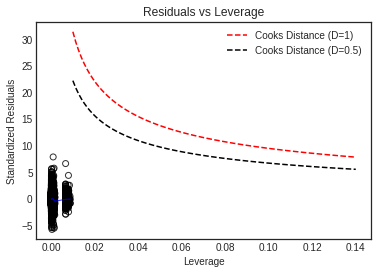

In [ ]:
## Modelo Completo
# Não há nenhum outlier/observação capaz de alterar significativamente os resultados do modelo,
# o que ocorre mais por conta do grande número de observações usadas
cooks_distance(modelo_completo)

## E a hipótese de não-correlação das variáveis exógenas e do erro?

Quando existe uma variável correlacionada com algum termo de erro, dizemos que ela é **endógena**. O caso mais comum é a **educação**, correlacionada com a aptidão não-observada (que, justamente por isso, é relegada ao termo de erro).

Assim, como testar para a endogeneidade? Antes de tudo, é preciso instrumentá-la!

Instrumentar uma variável (que foi o que rendeu a uns dos laureados desse ano o nobel de economia) é encontrar outras variáveis que são correlacionadas com ela, mas não com o termo de erro e que não estão presentes no modelo original.

Assim, regredimos a variável endógena sobre essa(s) variáveis exógenas adicionais - além das outras variáveis exógenas do nosso modelo -, e, com os valores previstos, estimamos o modelo original.

Esse procedimento é chamado de **Mínimos Quadrados em Dois Estágios** (MQ2E ou, em inglês, 2SLS).


### Instrumento de educação: educação_conjugue

Outro instrumento possível é a educação dos pais (difícil por se tratar de uma pesquisa domiciliar).

A variável funciona porque pessoas de educação semelhante tendem a se casar entre si.

In [ ]:
# Ordenando o dataframe por domícilio, por data e por condição no domicílio (V2005)
# 1: chefe de domicílio; 2: conjugue...
df.sort_values(by=['iddom','V2005'], inplace=True)

In [ ]:
## Criando colunas auxiliares (uma linha pra cima e uma linha pra baixo)
# educ: VD3005
df['educ-1'] = df['educ'].shift(-1)
df['educ+1'] = df['educ'].shift(1)

In [ ]:
## Criando mais uma coluna auxiliar (condicão no domicílio da pessoa de baixo)
df[['V2005-1']] = df['V2005'].shift(-1)

In [ ]:
## Criando mais colunas auxiliares (uma linha pra cima e uma linha pra baixo)
# para determinar se pessoas estão no mesmo domicílio ou não
df['iddom-1'] = df['iddom'].shift(-1)
df['iddom+1'] = df['iddom'].shift(1)

In [ ]:
## Vendo colunas relevantes
df[['iddom','idind','V2005','educ','V2005-1', 'educ-1', 'iddom-1','educ+1','iddom+1']].head(10)

,iddom,idind,V2005,educ,V2005-1,educ-1,iddom-1,educ+1,iddom+1
190085,500000265117,5000002651172,2,6,1.0,12.0,500000265127,NaN,NaN
190086,500000265127,5000002651271,1,12,2.0,12.0,500000265127,6.0,500000265117
190087,500000265127,5000002651272,2,12,1.0,5.0,500000265137,12.0,500000265127
190088,500000265137,5000002651371,1,5,5.0,5.0,500000265147,12.0,500000265127
190089,500000265147,5000002651472,5,5,1.0,10.0,50000026567,5.0,500000265137
190077,50000026567,500000265671,1,10,2.0,12.0,50000026567,5.0,500000265147
190078,50000026567,500000265672,2,12,1.0,16.0,50000026577,10.0,50000026567
190079,50000026577,500000265771,1,16,2.0,16.0,50000026577,12.0,50000026567
190080,50000026577,500000265772,2,16,5.0,11.0,50000026577,16.0,50000026577
190081,50000026577,500000265773,5,11,2.0,9.0,50000026587,16.0,50000026577


In [ ]:
def educ_conjugue(s):
  ## Se a pessoa estiver registrada como casada, retorne a sua educação
  # (que estará na linha do chefe do domicílio)
    if ((s['V2005'] == 2) or (s['V2005'] == 3)) and (s['iddom'] == s['iddom+1']):
        return s['educ+1']

    # Se a pessoa for chefe de domicílio e for casada (cuidado com o domicílio), retorne a educação dessa pessoa
    elif (s['V2005'] == 1) and ((s['V2005-1'] == 2) or (s['V2005-1'] == 3)) and (s['iddom'] == s['iddom-1']):
        return s['educ-1']

In [ ]:
df['educ_conjugue'] = df.apply(educ_conjugue, axis = 1)

In [ ]:
## Tiramos metade da amostra (sem conjugues) e, como esperado, conjugues possuem uma maior educação
df[['educ_conjugue','educ']].describe()

,educ_conjugue,educ
count,10382.000000,24212.000000
mean,11.198035,10.865645
std,3.943352,4.033675
min,0.000000,0.000000
25%,9.000000,8.000000
50%,12.000000,12.000000
75%,15.000000,14.000000
max,16.000000,16.000000


### Modelagem MQ2E

In [ ]:
## Modelo de MQ2E ou IV2SLS
# ! pip install linearmodels
from linearmodels.iv import IV2SLS, compare

In [ ]:
# Lembrar do intercepto (tem que ser explicitamente colocado como 1 nas funções desse módulo)
formula_mq2e = "lsalariohora ~ 1 + [educ ~ educ_conjugue] + idade + feminino + preta + parda + amarela + indigena"
modelo_mq2e = IV2SLS.from_formula(formula=formula_mq2e, data=df).fit()

## Printando o resultado (note que não há o ())
# IV2SLS possui erros robustos por padrão
print(modelo_mq2e.summary)

## Retorno da educação parece ser muito maior

                          IV-2SLS Estimation Summary                          
Dep. Variable:           lsalariohora   R-squared:                      0.2491
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2486
No. Observations:               10382   F-statistic:                    2721.7
Date:                Tue, Oct 19 2021   P-value (F-stat)                0.0000
Time:                        23:48:12   Distribution:                  chi2(7)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.3659     0.0559     6.5510     0.0000      0.2564      0.4754
idade          0.0169     0.0007     23.505     0.00

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [ ]:
## Comparando com MQO
modelo_simples_heteroscedasticidade_iv = IV2SLS.from_formula(formula=formula_simples, data=df).fit(cov_type="robust")
print(compare({'MQO':modelo_simples_heteroscedasticidade_iv, 'MQ2E':modelo_mq2e}, precision = 'std_errors', stars=True).summary)

                   Model Comparison                   
                                  MQO             MQ2E
------------------------------------------------------
Dep. Variable            lsalariohora     lsalariohora
Estimator                         OLS          IV-2SLS
No. Observations                24212            10382
Cov. Est.                      robust           robust
R-squared                      0.2827           0.2491
Adj. R-squared                 0.2825           0.2486
F-statistic                    7267.2           2721.7
P-value (F-stat)               0.0000           0.0000
==================     ==============   ==============
Intercept                   0.8430***        0.3659***
                             (0.0236)         (0.0559)
educ                        0.0967***        0.1489***
                             (0.0012)         (0.0033)
idade                       0.0178***        0.0169***
                             (0.0004)         (0.0007)
feminino  

In [ ]:
# Lembrar do intercepto (tem que ser explicitamente colocado como 1 nas funções desse módulo)
formula_mq2e_completo = "lsalariohora ~ 1 + [educ ~ educ_conjugue] + idade + idadesq + feminino + preta + parda + amarela + indigena"
modelo_mq2e_completo = IV2SLS.from_formula(formula=formula_mq2e_completo, data=df).fit()

## Printando o resultado (note que não há o ())
# IV2SLS possui erros robustos por padrão
print(modelo_mq2e_completo.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:           lsalariohora   R-squared:                      0.2573
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2567
No. Observations:               10382   F-statistic:                    2948.3
Date:                Wed, Oct 20 2021   P-value (F-stat)                0.0000
Time:                        00:43:01   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.3409     0.0988    -3.4494     0.0006     -0.5345     -0.1472
idade          0.0548     0.0048     11.478     0.00

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [ ]:
# Lembrar do intercepto (tem que ser explicitamente colocado como 1 nas funções desse módulo)
formula_mq2e_completo1 = "lsalariohora ~ 1 + [educ ~ educ_conjugue] + idade + idadesq + feminino + preta + parda + amarela + indigena + C(VD4009)"
modelo_mq2e_completo1 = IV2SLS.from_formula(formula=formula_mq2e_completo1, data=df).fit()

## Printando o resultado (note que não há o ())
# IV2SLS possui erros robustos por padrão
print(modelo_mq2e_completo1.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:           lsalariohora   R-squared:                      0.3282
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3271
No. Observations:               10382   F-statistic:                    4966.4
Date:                Wed, Oct 20 2021   P-value (F-stat)                0.0000
Time:                        00:44:58   Distribution:                 chi2(17)
Cov. Estimator:                robust                                         
                                                                              
                                        Parameter Estimates                                        
                                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------------
Intercept                           0.0611     0.0998     0.6123    

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [ ]:
## Vendo os resultados de primeiro estágio (estimação de educ)
# R2 de 0,42; um ano a mais de educ_conjugue implica a pessoa ter 0,6 anos a mais de educação
# Mais instrumentos são necessários para instrumentar de educ de forma mais acurada
print(modelo_mq2e.first_stage)

    First Stage Estimation Results    
                                  educ
--------------------------------------
R-squared                       0.4206
Partial R-squared               0.3616
Shea's R-squared                0.3616
Partial F-statistic             5096.3
P-value (Partial F-stat)        0.0000
Partial F-stat Distn           chi2(1)
========================== ===========
Intercept                       5.4206
                              (29.062)
idade                          -0.0362
                             (-11.877)
feminino                        1.8361
                              (31.385)
preta                          -0.6418
                             (-5.7450)
parda                          -0.5756
                             (-8.9629)
amarela                        -0.2313
                             (-0.6783)
indigena                       -0.7195
                             (-2.1254)
educ_conjugue                   0.5988
                         

### E isso tudo era necessário mesmo? Testando endogeneidade de educ

In [ ]:
## E isso tudo era necessário mesmo? Testando endogeneidade de educ
# educ é com 100% de certeza endógeno
modelo_mq2e.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 426.0043
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f50c43c7a10

In [ ]:
modelo_mq2e_completo1.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 378.3537
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f50af07bd90

Podemos tratar endogeneidade com uma variável instrumental.

Contudo, precisamos garantir que os instrumentos são relevantes e exógenos, o que pode ser díficil de conseguir na vida real.

Nesse sentido, podemos usar **modelos de painel** quando há mais de uma observação por indivíduo ao longo do tempo para expurgar essas características não-observáveis relegados ao termo de erro.